# def

In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 300
import math
import datetime as dt
from tableone import TableOne, load_dataset
import itertools
import random
import scipy.stats as stats

In [ ]:
df_type = pd.read_csv("df_mixAK_fea4_C3.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("Number of included patients:",len(all_lst))

df_type_filt["groupHPD"].value_counts()

# The length of the entire course of SAKI

In [3]:
df_first_aki = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_first_and_max_stage.csv")
first_aki_lst = df_first_aki[df_first_aki.first_aki_stage == 1].stay_id.unique()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## sepsis to sa-aki

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.659e-01 U_stat=1.274e+06
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.086e-09 U_stat=4.201e+05


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:8.730e-07 U_stat=1.740e+05


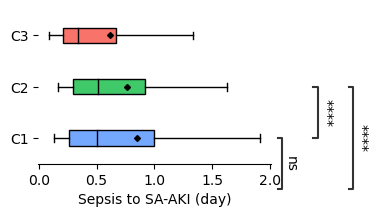

In [4]:
df_time_all = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/04.other_feature_in_three_dataset/04.survival_treatment/df_time_all.csv")
dataset_dict = {"mimic":"MIMIC","aumcdb":"AUMCdb","eicu":"eICU"}
df_time_all = df_time_all[df_time_all["dataset"]=="mimic"]
df_time_all = df_time_all[df_time_all["stay_id"].isin(first_aki_lst)]
df_time_all["los_saki-sepsis"] = df_time_all["los_saki-sepsis"]/24

import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(3,2))
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

f1 = plt.boxplot([df_time_all[df_time_all["groupHPD"]==1]["los_saki-sepsis"], df_time_all[df_time_all["groupHPD"]==2]["los_saki-sepsis"], df_time_all[df_time_all["groupHPD"]==3]["los_saki-sepsis"]],
           whis=(10,90),showfliers=False,showmeans=True,vert=False,patch_artist=True,meanprops={'marker':'D','markerfacecolor':'black','markersize':3,'markeredgecolor':'black'},medianprops={'color':'black'}) 

color = ["#74a8ff","#3fc968","#f8746a"]
for box,c in zip(f1['boxes'], color):
    box.set(facecolor = c,edgecolor='black')
plt.xlabel("Sepsis to SA-AKI (day)")
plt.yticks([1,2,3],["C1","C2","C3"]) 


from statannotations.Annotator import Annotator
box_pairs = [(2,1),(3,1),(3,2)]
fig_args = {'x': 'groupHPD',
            'y': 'los_saki-sepsis',
            'data': df_time_all,
            'dodge': True}
annotator = Annotator(ax=ax, pairs=box_pairs, **fig_args)

fig_args_horiz = {**fig_args,'x': 'los_saki-sepsis', 'y': 'groupHPD'}
configuration = {'test':'Mann-Whitney', 'comparisons_correction':None, 'text_format':'star', 'loc':'outside'}
annotator.new_plot(ax, orient='h', **fig_args_horiz)
annotator.configure(**configuration).apply_test()
annotator.apply_and_annotate()
plt.savefig('./result/mimic_time_interval_sepsis2saaaki.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# Output the median, mean and quantiles of each data group
data_groups = [
    df_time_all[df_time_all["groupHPD"]==1]["los_saki-sepsis"], 
    df_time_all[df_time_all["groupHPD"]==2]["los_saki-sepsis"], 
    df_time_all[df_time_all["groupHPD"]==3]["los_saki-sepsis"]
]

df_out = pd.DataFrame(columns = ["class","Mean","q10","q25","q50","q75","q90"])
for i, group_data in enumerate(data_groups):
    i = "C" + str(int(i)+1) 
    mean = round(np.mean(group_data),2)
    q10 = round(np.percentile(group_data, 10),2)
    q25 = round(np.percentile(group_data, 25),2)
    q50 = round(np.percentile(group_data, 50),2)
    q75 = round(np.percentile(group_data, 75),2)
    q90 = round(np.percentile(group_data, 90),2)
    df_out.loc[len(df_out)] = [i,mean,q10,q25,q50,q75,q90]
df_out

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,class,Mean,q10,q25,q50,q75,q90
0,C1,0.85,0.13,0.26,0.50,1.00,1.92
1,C2,0.76,0.17,0.29,0.52,0.92,1.62
2,C3,0.62,0.09,0.21,0.33,0.67,1.34


## first AKI stage to max AKI stages

In [ ]:
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_first_and_max_stage.csv")
df_time = pd.merge(df_time,df_type_filt,how="inner",on="stay_id")
print("Patients with two-thirds of AKI at the initial diagnosis stage:",df_time[df_time["first_aki_stage"].isin([ 3])].shape[0])
df_time = df_time[~df_time["first_aki_stage"].isin([ 3])]

df_time["first_aki_onset"] = pd.to_datetime(df_time["first_aki_onset"])
df_time["max_aki_time"] = pd.to_datetime(df_time["max_aki_time"])
df_time = df_time[df_time["max_aki_stage"]!=df_time["first_aki_stage"]]
df_time["during_time"] = (df_time["max_aki_time"] - df_time["first_aki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()
# df_time["dealt_aki_stage"] = df_time["max_aki_stage"] - df_time["first_aki_stage"]
# df_time.loc[df_time["dealt_aki_stage"]==0, "dealt_aki_stage"] = 1
# df_time["during_time"] = round(df_time["during_time"]/df_time["dealt_aki_stage"],0)
#df_time = df_time.dropna(how='any', subset=['during_time'])
print(len(df_time.stay_id.unique()))

import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(3,2))
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False) 
f1 = plt.boxplot([df_time[df_time["groupHPD"]==1]["during_time"], df_time[df_time["groupHPD"]==2]["during_time"], df_time[df_time["groupHPD"]==3]["during_time"]],
           whis=(10,90),showfliers=False,showmeans=True,vert=False,patch_artist=True,meanprops={'marker':'D','markerfacecolor':'black','markersize':3,'markeredgecolor':'black'},medianprops={'color':'black'}) 
color = ["#74a8ff","#3fc968","#f8746a"]
for box,c in zip(f1['boxes'], color):
    box.set(facecolor = c,edgecolor='black')
    
plt.xlim(0,7.1)     
plt.xlabel("First to Max AKI_stages (day)")
plt.yticks([1,2,3],["C1","C2","C3"]) 

from statannotations.Annotator import Annotator
box_pairs = [(2,1),(3,1),(3,2)]
fig_args = {'x': 'groupHPD',
            'y': 'during_time',
            'data': df_time,
            'dodge': True}
annotator = Annotator(ax=ax, pairs=box_pairs, **fig_args)

fig_args_horiz = {**fig_args,'x': 'during_time', 'y': 'groupHPD'}
configuration = {'test':'Mann-Whitney', 'comparisons_correction':None, 'text_format':'star', 'loc':'outside'}
annotator.new_plot(ax, orient='h', **fig_args_horiz)
annotator.configure(**configuration).apply_test()
annotator.apply_and_annotate()
plt.savefig('./result/mimic_time_interval_first2max_AKIstages.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# Output the median, mean and quantiles of each data group
data_groups = [df_time[df_time["groupHPD"]==1]["during_time"],
               df_time[df_time["groupHPD"]==2]["during_time"], 
               df_time[df_time["groupHPD"]==3]["during_time"]]

df_out = pd.DataFrame(columns = ["class","Mean","q10","q25","q50","q75","q90"])
for i, group_data in enumerate(data_groups):
    i = "C" + str(int(i)+1) 
    mean = round(np.mean(group_data),2)
    q10 = round(np.percentile(group_data, 10),2)
    q25 = round(np.percentile(group_data, 25),2)
    q50 = round(np.percentile(group_data, 50),2)
    q75 = round(np.percentile(group_data, 75),2)
    q90 = round(np.percentile(group_data, 90),2)
    df_out.loc[len(df_out)] = [i,mean,q10,q25,q50,q75,q90]
df_out

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,class,Mean,q10,q25,q50,q75,q90
0,C1,1.08,0.12,0.21,0.46,1.29,3.05
1,C2,0.65,0.08,0.17,0.25,0.74,1.72
2,C3,1.11,0.21,0.33,0.71,1.43,2.85


## first AKI to AKI endtime (with a 7-day limit)

In [ ]:
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_first_and_max_stage.csv")
df_time = pd.merge(df_time,df_type_filt,how="inner",on="stay_id")
print("Patients with two-thirds of AKI at the initial diagnosis stage:",df_time[df_time["first_aki_stage"].isin([2,3])].shape[0])
df_time = df_time[~df_time["first_aki_stage"].isin([2,3])]

df_time["first_aki_onset"] = pd.to_datetime(df_time["first_aki_onset"])
df_time["aki_endtime"] = pd.to_datetime(df_time["aki_endtime"])
df_time["during_time"] = (df_time["aki_endtime"] - df_time["first_aki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()
# df_time["dealt_aki_stage"] = df_time["max_aki_stage"] - df_time["first_aki_stage"]
# df_time.loc[df_time["dealt_aki_stage"]==0, "dealt_aki_stage"] = 1
# df_time["during_time"] = round(df_time["during_time"]/df_time["dealt_aki_stage"],0)
#df_time = df_time.dropna(how='any', subset=['during_time'])
print(len(df_time.stay_id.unique()))

import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(3,2))
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False) 
f1 = plt.boxplot([df_time[df_time["groupHPD"]==1]["during_time"], df_time[df_time["groupHPD"]==2]["during_time"], df_time[df_time["groupHPD"]==3]["during_time"]],
           whis=(10,90),showfliers=False,showmeans=True,vert=False,patch_artist=True,meanprops={'marker':'D','markerfacecolor':'black','markersize':3,'markeredgecolor':'black'},medianprops={'color':'black'}) 
color = ["#74a8ff","#3fc968","#f8746a"]
for box,c in zip(f1['boxes'], color):
    box.set(facecolor = c,edgecolor='black')
plt.xlim(0,7)  
plt.xlabel("First to end AKI_stages (day)")
plt.yticks([1,2,3],["C1","C2","C3"]) 

from statannotations.Annotator import Annotator
box_pairs = [(2,1),(3,1),(3,2)]
fig_args = {'x': 'groupHPD',
            'y': 'during_time',
            'data': df_time,
            'dodge': True}
annotator = Annotator(ax=ax, pairs=box_pairs, **fig_args)

fig_args_horiz = {**fig_args,'x': 'during_time', 'y': 'groupHPD'}
configuration = {'test':'Mann-Whitney', 'comparisons_correction':None, 'text_format':'star', 'loc':'outside'}
annotator.new_plot(ax, orient='h', **fig_args_horiz)
annotator.configure(**configuration).apply_test()
annotator.apply_and_annotate()
plt.savefig('./result/mimic_time_interval_first2end_AKIstages_in7day.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# Output the median, mean and quantiles of each data group
data_groups = [df_time[df_time["groupHPD"]==1]["during_time"],
               df_time[df_time["groupHPD"]==2]["during_time"],
               df_time[df_time["groupHPD"]==3]["during_time"]]

df_out = pd.DataFrame(columns = ["class","Mean","q10","q25","q50","q75","q90"])

for i, group_data in enumerate(data_groups):
    i = "C" + str(int(i)+1) 
    mean = round(np.mean(group_data),2)
    q10 = round(np.percentile(group_data, 10),2)
    q25 = round(np.percentile(group_data, 25),2)
    q50 = round(np.percentile(group_data, 50),2)
    q75 = round(np.percentile(group_data, 75),2)
    q90 = round(np.percentile(group_data, 90),2)
    df_out.loc[len(df_out)] = [i,mean,q10,q25,q50,q75,q90]
df_out

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,class,Mean,q10,q25,q50,q75,q90
0,C1,3.47,0.83,1.48,3.08,5.57,6.82
1,C2,2.43,0.46,0.88,1.62,3.50,6.15
2,C3,3.83,1.03,1.58,3.25,6.68,6.97


In [ ]:
# Output the median, mean and quantiles of each data group
data_groups = [df_time["during_time"],
               df_time[df_time["groupHPD"]==1]["during_time"],
               df_time[df_time["groupHPD"]==2]["during_time"],
               df_time[df_time["groupHPD"]==3]["during_time"]]

df_out = pd.DataFrame(columns = ["class","Mean","q10","q25","q50","q75","q90"])
for i, group_data in enumerate(data_groups):
    i = "C" + str(int(i)) 
    mean = round(np.mean(group_data)/24,1)
    q10 = round(np.percentile(group_data, 10)/24,1)
    q25 = round(np.percentile(group_data, 25)/24,1)
    q50 = round(np.percentile(group_data, 50)/24,1)
    q75 = round(np.percentile(group_data, 75)/24,1)
    q90 = round(np.percentile(group_data, 90)/24,1)
    df_out.loc[len(df_out)] = [i,mean,q10,q25,q50,q75,q90]
df_out
# C0 refer to all patients

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,class,Mean,q10,q25,q50,q75,q90
0,C0,0.1,0.0,0.0,0.1,0.2,0.3
1,C1,0.1,0.0,0.1,0.1,0.2,0.3
2,C2,0.1,0.0,0.0,0.1,0.1,0.3
3,C3,0.2,0.0,0.1,0.1,0.3,0.3


In [11]:
print("all:"+str(df_out.iloc[0,4])+"["+str(df_out.iloc[0,3])+"," +str(df_out.iloc[0,5]) +"]")
print("C1:"+str(df_out.iloc[1,4])+"["+str(df_out.iloc[1,3])+"," +str(df_out.iloc[1,5]) +"]")
print("C2:"+str(df_out.iloc[2,4])+"["+str(df_out.iloc[2,3])+"," +str(df_out.iloc[2,5]) +"]")
print("C3:"+str(df_out.iloc[3,4])+"["+str(df_out.iloc[3,3])+"," +str(df_out.iloc[3,5]) +"]")

all:0.1[0.0,0.2]
C1:0.1[0.1,0.2]
C2:0.1[0.0,0.1]
C3:0.1[0.1,0.3]


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
import scipy.stats as stats
f_statistic, p_value = stats.f_oneway(data_groups[1],data_groups[2],data_groups[3])
print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 124.93971260503822
P-value: 2.8476045647223716e-53


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from scipy.stats import ranksums
for v in [[1,2],[1,3],[2,3]]:
    i = v[0]
    j = v[1]
    print(i,j)
    data1 = data_groups[i]
    data2 = data_groups[j]
    differences = [x - y for x, y in zip(data1, data2)]
    statistic, p_value = ranksums(data1, data2)
    print("Rank sum test statistic:", statistic)
    print("p value:", p_value)

## first AKI to AKI endtime (no 7-day limit)

In [ ]:
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_first_and_max_stage.csv")
df_time = pd.merge(df_time,df_type_filt,how="inner",on="stay_id")
print("Patients with two-thirds of AKI at the initial diagnosis stage:",df_time[df_time["first_aki_stage"].isin([2,3])].shape[0])
df_time = df_time[~df_time["first_aki_stage"].isin([2,3])]

df_time["first_aki_onset"] = pd.to_datetime(df_time["first_aki_onset"])
df_time["aki_endtime_H7D"] = pd.to_datetime(df_time["aki_endtime_H7D"])
df_time["during_time"] = (df_time["aki_endtime_H7D"] - df_time["first_aki_onset"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
# df_time["dealt_aki_stage"] = df_time["max_aki_stage"] - df_time["first_aki_stage"]
# df_time.loc[df_time["dealt_aki_stage"]==0, "dealt_aki_stage"] = 1
# df_time["during_time"] = round(df_time["during_time"]/df_time["dealt_aki_stage"],0)
#df_time = df_time.dropna(how='any', subset=['during_time'])
print(len(df_time.stay_id.unique()))

import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(3,2))
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False) 
f1 = plt.boxplot([df_time[df_time["groupHPD"]==1]["during_time"], df_time[df_time["groupHPD"]==2]["during_time"], df_time[df_time["groupHPD"]==3]["during_time"]],
           whis=(10,90),showfliers=False,showmeans=True,vert=False,patch_artist=True,meanprops={'marker':'D','markerfacecolor':'black','markersize':3,'markeredgecolor':'black'},medianprops={'color':'black'}) 
color = ["#74a8ff","#3fc968","#f8746a"]
for box,c in zip(f1['boxes'], color):
    box.set(facecolor = c,edgecolor='black')
    
plt.xlabel("First to end AKI_stages (Hours)")
plt.yticks([1,2,3],["C1","C2","C3"]) 

from statannotations.Annotator import Annotator
box_pairs = [(2,1),(3,1),(3,2)]
fig_args = {'x': 'groupHPD',
            'y': 'during_time',
            'data': df_time,
            'dodge': True}
annotator = Annotator(ax=ax, pairs=box_pairs, **fig_args)

fig_args_horiz = {**fig_args,'x': 'during_time', 'y': 'groupHPD'}
configuration = {'test':'Mann-Whitney', 'comparisons_correction':None, 'text_format':'star', 'loc':'outside'}
annotator.new_plot(ax, orient='h', **fig_args_horiz)
annotator.configure(**configuration).apply_test()
annotator.apply_and_annotate()
plt.savefig('./result/mimic_time_interval_first2end_AKIstages_no7day.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# Output the median, mean and quantiles of each data group
data_groups = [df_time[df_time["groupHPD"]==1]["during_time"],
               df_time[df_time["groupHPD"]==2]["during_time"],
               df_time[df_time["groupHPD"]==3]["during_time"]]

df_out = pd.DataFrame(columns = ["class","Mean","q10","q25","q50","q75","q90"])
for i, group_data in enumerate(data_groups):
    i = "C" + str(int(i)+1) 
    mean = round(np.mean(group_data),2)
    q10 = round(np.percentile(group_data, 10),2)
    q25 = round(np.percentile(group_data, 25),2)
    q50 = round(np.percentile(group_data, 50),2)
    q75 = round(np.percentile(group_data, 75),2)
    q90 = round(np.percentile(group_data, 90),2)
    df_out.loc[len(df_out)] = [i,mean,q10,q25,q50,q75,q90]
df_out

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,class,Mean,q10,q25,q50,q75,q90
0,C1,132.59,21.35,37.10,79.7,159.72,317.40
1,C2,91.31,12.00,22.00,42.0,101.00,235.09
2,C3,150.21,24.81,37.85,78.0,192.38,332.00


## first AKI to outICU

In [ ]:
df_icu = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_event_time.csv")
df_icu = df_icu[["stay_id","saki_onset","outtime"]]
df_icu = pd.merge(df_icu,df_type_filt,how="inner",on="stay_id")
df_icu["saki_onset"] = pd.to_datetime(df_icu["saki_onset"])
df_icu["outtime"] = pd.to_datetime(df_icu["outtime"])
print(len(df_icu.stay_id.unique()))

df_icu["during_time"] = (df_icu["outtime"] - df_icu["saki_onset"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()

import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(3,2))
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False) 
f1 = plt.boxplot([df_icu[df_icu["groupHPD"]==1]["during_time"], df_icu[df_icu["groupHPD"]==2]["during_time"], df_icu[df_icu["groupHPD"]==3]["during_time"]],
           whis=(10,90),showfliers=False,showmeans=True,vert=False,patch_artist=True,meanprops={'marker':'D','markerfacecolor':'black','markersize':3,'markeredgecolor':'black'},medianprops={'color':'black'}) 
color = ["#74a8ff","#3fc968","#f8746a"]
for box,c in zip(f1['boxes'], color):
    box.set(facecolor = c,edgecolor='black')
    
plt.xlabel("First diagnose to out ICU (Hours)")
plt.yticks([1,2,3],["C1","C2","C3"]) 

from statannotations.Annotator import Annotator
box_pairs = [(2,1),(3,1),(3,2)]
fig_args = {'x': 'groupHPD',
            'y': 'during_time',
            'data': df_time,
            'dodge': True}
annotator = Annotator(ax=ax, pairs=box_pairs, **fig_args)

fig_args_horiz = {**fig_args,'x': 'during_time', 'y': 'groupHPD'}
configuration = {'test':'Mann-Whitney', 'comparisons_correction':None, 'text_format':'star', 'loc':'outside'}
annotator.new_plot(ax, orient='h', **fig_args_horiz)
annotator.configure(**configuration).apply_test()
annotator.apply_and_annotate()
plt.savefig('./result/mimic_time_interval_first2out_AKI.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# Output the median, mean and quantiles of each data group
data_groups = [
    df_icu[df_icu["groupHPD"]==1]["during_time"], 
    df_icu[df_icu["groupHPD"]==2]["during_time"], 
    df_icu[df_icu["groupHPD"]==3]["during_time"]
]

df_out = pd.DataFrame(columns = ["class","Mean","q10","q25","q50","q75","q90"])
for i, group_data in enumerate(data_groups):
    i = "C" + str(int(i)+1) 
    mean = round(np.mean(group_data),2)
    q10 = round(np.percentile(group_data, 10),2)
    q25 = round(np.percentile(group_data, 25),2)
    q50 = round(np.percentile(group_data, 50),2)
    q75 = round(np.percentile(group_data, 75),2)
    q90 = round(np.percentile(group_data, 90),2)
    df_out.loc[len(df_out)] = [i,mean,q10,q25,q50,q75,q90]
df_out